In [88]:
import time
import copy
import numpy as np
from skimage.filters import gaussian_filter
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Load time-lapse data...

In [89]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
# filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/jug/Dropbox/ProjectGoldstein/2017-01-17_from_Mark/MAX_LP409_ventral-Concat_CROP_RGB_test.tif'

stack = imread(filename)
print 'Stack shape:',stack.shape

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian_filter(segchannel,sigma)

print 'Segchannel shape:',segchannel.shape
print 'Single image:',segchannel[0].shape

Stack shape: (20, 2, 542, 919)


/Users/jug/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


Segchannel shape: (20, 542, 919)
Single image: (542, 919)


In [90]:
max_rs = (segchannel[0].shape[1] / 3,
          segchannel[0].shape[1] / 3)

min_rs = (5,5)
print min_rs, max_rs

(5, 5) (306, 306)


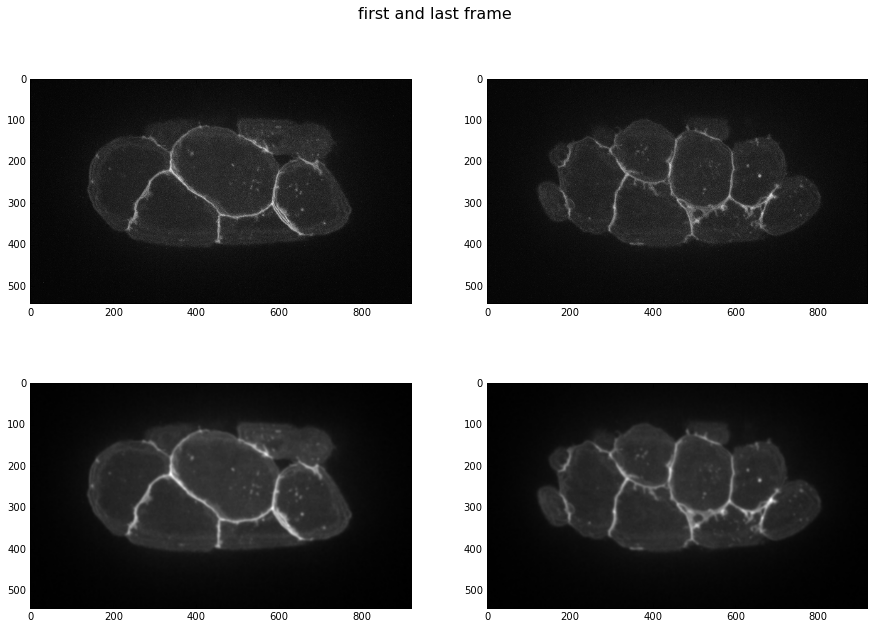

In [91]:
fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(segchannel_smooth[-1], plt.get_cmap('gray'))

# Adding cells

In [92]:
data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

### Ea

In [93]:
Ea = data.init_object("Ea")
objects.append(Ea)

In [94]:
data.add_object_at( Ea, min_rs, max_rs, frame=0, seed=(230,240), segment_it=True )
data.track(Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ea" in frame 0 with seed coordinates [ 230.  240.]
      Optimum energy:  0.0749448912184
      Nodes in/out:  2066 5134
      Area:  23878.0
Added appearance for "Ea" in frame 1 with seed coordinates [ 230.  240.]
      Optimum energy:  0.0676853046455
      Nodes in/out:  2099 5101
      Area:  24432.5
    Updated center to [228 239]
Added appearance for "Ea" in frame 2 with seed coordinates [ 228.  239.]
      Optimum energy:  0.0612515016383
      Nodes in/out:  2094 5106
      Area:  24246.0
    Updated center to [229 240]
Added appearance for "Ea" in frame 3 with seed coordinates [ 229.  240.]
      Optimum energy:  0.062530624679
      Nodes in/out:  2085 5115
      Area:  23884.0
    Updated center to [229 240]
Added appearance for "Ea" in frame 4 with seed coordinates [ 229.  240.]
      Optimum energy:  0.0620053683757
      Nodes in/out:  2097 5103
      Area:  24250.5
    Updated center to [230 242]
Added appearance for "Ea" in frame 5 with seed coordi

In [95]:
data.segment2dt( Ea, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1.43327436143
      Area:  23960.5
Results for frame 1:
      Optimum energy:  1.43327436143
      Area:  24190.0
Results for frame 2:
      Optimum energy:  1.43327436143
      Area:  24059.5
Results for frame 3:
      Optimum energy:  1.43327436143
      Area:  24119.0
Results for frame 4:
      Optimum energy:  1.43327436143
      Area:  24695.0
Results for frame 5:
      Optimum energy:  1.43327436143
      Area:  24628.0
Results for frame 6:
      Optimum energy:  1.43327436143
      Area:  24614.0
Results for frame 7:
      Optimum energy:  1.43327436143
      Area:  24925.0
Results for frame 8:
      Optimum energy:  1.43327436143
      Area:  25122.5
Results for frame 9:
      Optimum energy:  1.43327436143
      Area:  24625.0
Results for frame 10:
      Optimum energy:  1.43327436143
      Area:  24423.5
Results for frame 11:
      Optimum energy:  1.43327436143
      Area:  23909.0
Results for frame 12:
      Optimum energy:  1.433

### Ep

In [9]:
Ep = data.init_object("Ep")
objects.append(Ep)

In [10]:
data.add_object_at( Ep, min_rs, max_rs, frame=0, seed=(350,330), segment_it=True )
data.track(Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ep" in frame 0 with seed coordinates [ 350.  330.]
      Optimum energy:  0.0862175998874
      Nodes in/out:  2018 5182
      Area:  23079.0
Added appearance for "Ep" in frame 1 with seed coordinates [ 350.  330.]
      Optimum energy:  0.0887357557211
      Nodes in/out:  2022 5178
      Area:  23003.5
    Updated center to [350 325]
Added appearance for "Ep" in frame 2 with seed coordinates [ 350.  325.]
      Optimum energy:  0.0855881869519
      Nodes in/out:  1979 5221
      Area:  21865.5
    Updated center to [352 323]
Added appearance for "Ep" in frame 3 with seed coordinates [ 352.  323.]
      Optimum energy:  0.0933677078443
      Nodes in/out:  1982 5218
      Area:  21786.0
    Updated center to [354 323]
Added appearance for "Ep" in frame 4 with seed coordinates [ 354.  323.]
      Optimum energy:  0.0908538576026
      Nodes in/out:  2015 5185
      Area:  22450.5
    Updated center to [355 324]
Added appearance for "Ep" in frame 5 with seed coord

In [11]:
data.segment2dt( Ep, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  31.9645703517
      Area:  22973.5
Results for frame 1:
      Optimum energy:  31.9645703517
      Area:  22229.5
Results for frame 2:
      Optimum energy:  31.9645703517
      Area:  21883.5
Results for frame 3:
      Optimum energy:  31.9645703517
      Area:  21895.0
Results for frame 4:
      Optimum energy:  31.9645703517
      Area:  21762.5
Results for frame 5:
      Optimum energy:  31.9645703517
      Area:  22014.0
Results for frame 6:
      Optimum energy:  31.9645703517
      Area:  22274.0
Results for frame 7:
      Optimum energy:  31.9645703517
      Area:  22212.5
Results for frame 8:
      Optimum energy:  31.9645703517
      Area:  22157.5
Results for frame 9:
      Optimum energy:  31.9645703517
      Area:  22644.5
Results for frame 10:
      Optimum energy:  31.9645703517
      Area:  22412.0
Results for frame 11:
      Optimum energy:  31.9645703517
      Area:  21976.5
Results for frame 12:
      Optimum energy:  31.96

# Save / Load 
_Does not work yet_

In [12]:
data.save('/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d.pkl')

In [ ]:
data = Data3d( segchannel, silent=False )
data.load('/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d.pkl')
objects = range(len(data.object_names))

# Visualisation stuff 

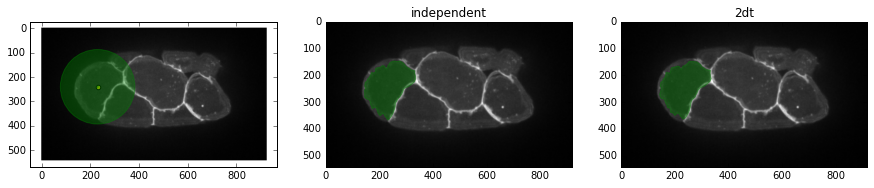

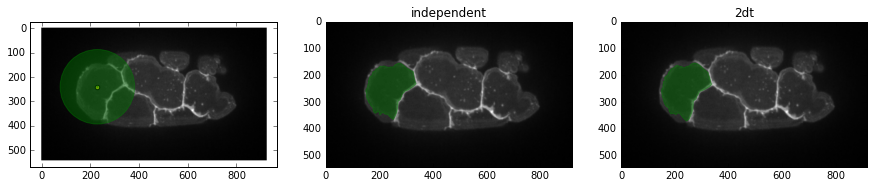

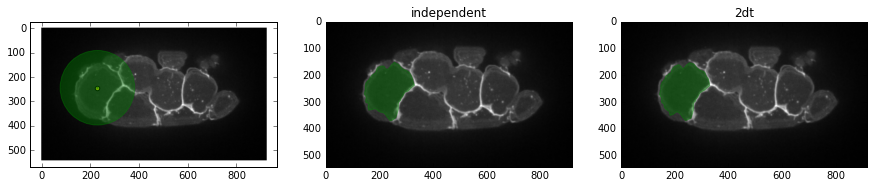

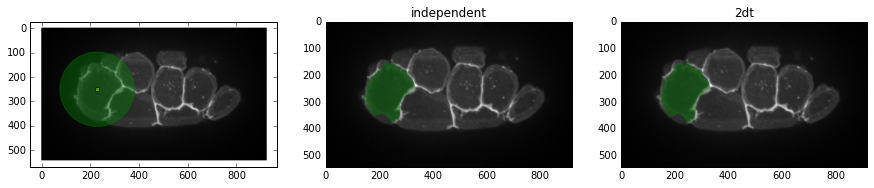

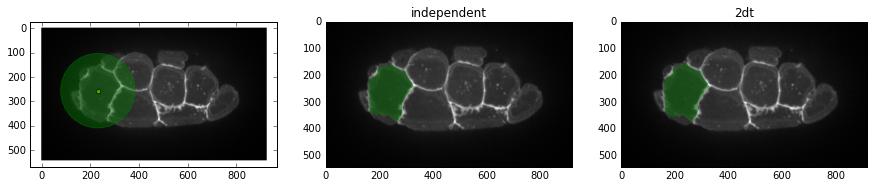

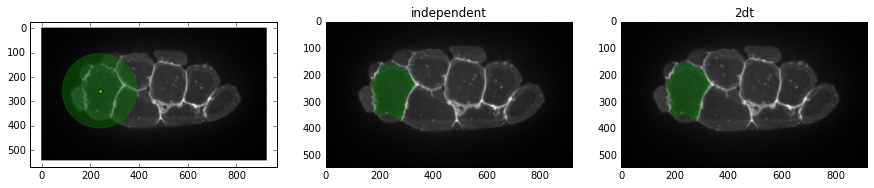

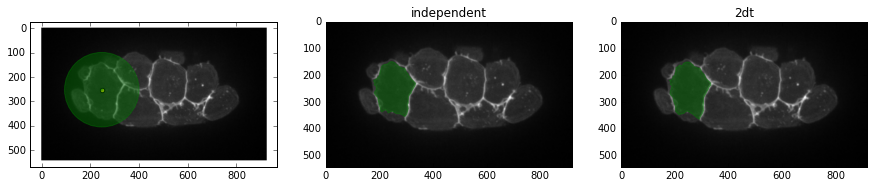

In [60]:
for frame in range(1,len(data.images),len(data.images)/6):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )

# FLOW

### See the loaded flow channel images...

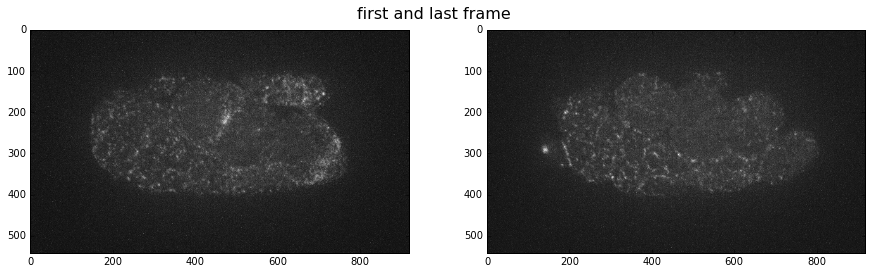

In [84]:
pylab.rcParams['figure.figsize'] = (15, 4)
fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))

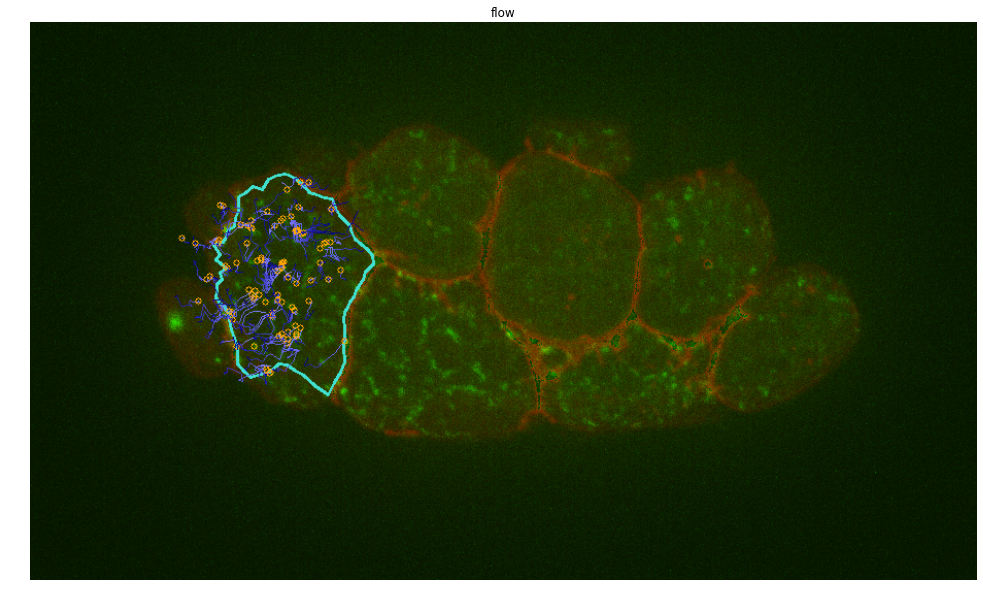

In [96]:
data.compute_flow( flowchannel, segchannel, folder='/Users/jug/Repositories/GIT/BobSeg/frames3d_tempconsistent/', show=True, inline=True )

# RADIAL VELOCITY vs FLOW 

In [16]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    '''
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    '''
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta

In [17]:
def unit_poly_verts(theta):
    '''
    Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    '''
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [18]:
def magnitude(v):
    return math.sqrt(sum(v[i]*v[i] for i in range(len(v))))

def add(u, v):
    return [ u[i]+v[i] for i in range(len(u)) ]

def sub(u, v):
    return [ u[i]-v[i] for i in range(len(u)) ]

def dot(u, v):
    return sum(u[i]*v[i] for i in range(len(u)))

def normalize(v):
    vmag = magnitude(v)
    return [ v[i]/vmag  for i in range(len(v)) ]

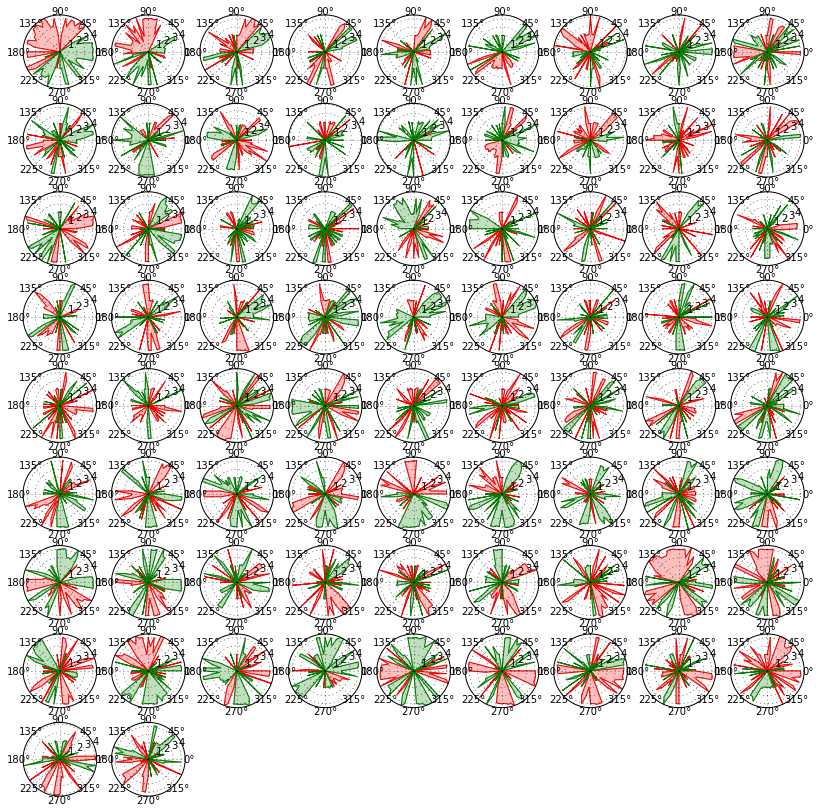

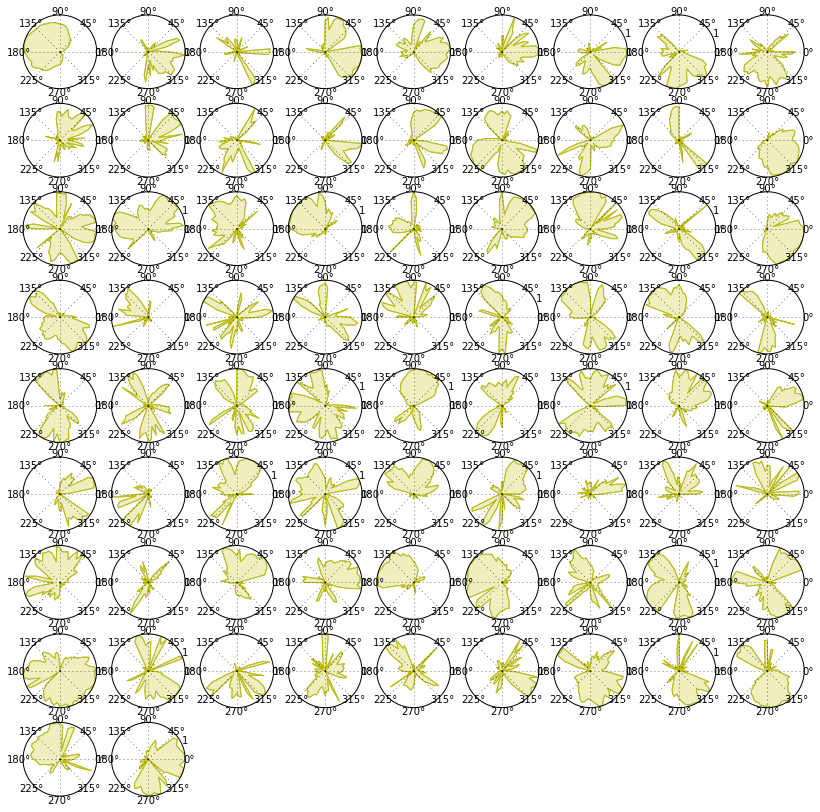

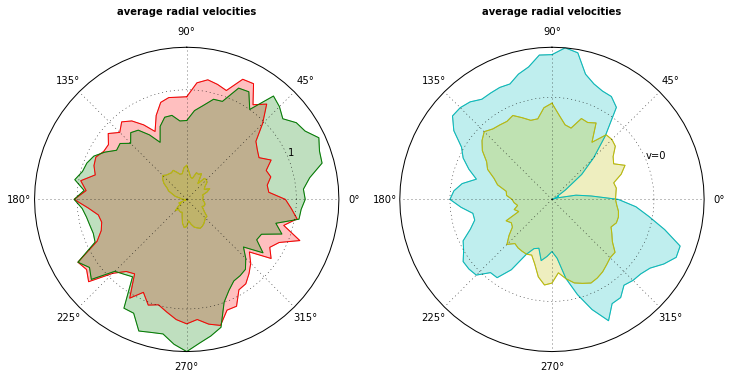

In [50]:
avg_v = np.zeros(data.num_columns)
avg_vplus = np.zeros_like(avg_v)
avg_vminus = np.zeros_like(avg_v)

theta = radar_factory(data.num_columns, frame='polygon')
fig = plt.figure(figsize=(14, 14))
T = len(data.images)-1
for t in range(T):
    ax = fig.add_subplot(int(T**.5+1), int(T**.5+1), t+1, projection='radar')
    plt.rgrids([1,2,3,4])
    #ax.set_title('radial velocities (t=%d)'%(t+1), weight='bold', size='medium', position=(0.5, 1.1),
    #                     horizontalalignment='center', verticalalignment='center')
    v = data.get_radial_velocities( Ea, t )
    vplus = np.maximum(v,np.zeros_like(v))
    vminus= np.minimum(v,np.zeros_like(v))*-1
    avg_v += v
    avg_vplus += vplus
    avg_vminus += vminus
    
    ax.plot(theta, vplus, color='r')
    ax.fill(theta, vplus, facecolor='r', alpha=0.25)
    ax.plot(theta, vminus, color='g')
    ax.fill(theta, vminus, facecolor='g', alpha=0.25)
avg_v /= T-1
avg_vplus /= T-1
avg_vminus /= T-1

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

avg_colprojlen = np.zeros(data.num_columns)

fig = plt.figure(figsize=(14, 14))
T = len(data.images)-1
for t in range(T):
    ax = fig.add_subplot(int(T**.5+1), int(T**.5+1), t+1, projection='radar')
    plt.rgrids([1,2,3,4])
    #ax.set_title('radial velocities (t=%d)'%(t+1), weight='bold', size='medium', position=(0.5, 1.1),
    #                     horizontalalignment='center', verticalalignment='center')
    col_flowvecs = data.get_all_flowvectors( Ea, t )
    col_avgvec = np.zeros( (len(col_flowvecs),2) )
    col_projected_length = np.zeros(len(col_flowvecs))
    for i,vecs in enumerate(col_flowvecs):
        avgvec = np.sum(vecs, axis=0) / len(col_flowvecs)
        col_avgvec[i] = avgvec
        col_projected_length[i] = dot(data.netsurfs[Ea][t].col_vectors[i], normalize(avgvec))
    avg_colprojlen += col_projected_length
    
    ax.plot(theta, col_projected_length, color='y')
    ax.fill(theta, col_projected_length, facecolor='y', alpha=0.25)
avg_colprojlen /= T-1
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 2, 1, projection='radar')
plt.rgrids([1,2,3,4])
ax.set_title('average radial velocities', weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
ax.plot(theta, avg_vplus, color='r')
ax.fill(theta, avg_vplus, facecolor='r', alpha=0.25)
ax.plot(theta, avg_vminus, color='g')
ax.fill(theta, avg_vminus, facecolor='g', alpha=0.25)
ax.plot(theta, avg_colprojlen, color='y')
ax.fill(theta, avg_colprojlen, facecolor='y', alpha=0.25)

ax = fig.add_subplot(1, 2, 2, projection='radar')
plt.rgrids([1])
ax.set_yticklabels(['v=0'])
ax.set_title('average radial velocities', weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
ax.plot(theta, avg_v+1, color='c')
ax.fill(theta, avg_v+1, facecolor='c', alpha=0.25)
ax.plot(theta, avg_colprojlen+1, color='y')
ax.fill(theta, avg_colprojlen+1, facecolor='y', alpha=0.25)